# Random Forest Modell mit festen Hyperparametern für Weinqualitäts-Vorhersage

Dieses Notebook trainiert ein Random Forest Modell zur Vorhersage der Weinqualität basierend auf den chemischen Eigenschaften des Weins. Die verwendeten Hyperparameter stammen aus einem zuvor ausgeführten GridSearch-Lauf (Screenshot vom 07.01.26) und werden hier als fixe Konfiguration verwendet.

**Workflow:**
1. Daten laden und vorbereiten
2. Modell-Training mit festen Hyperparametern (aus GridSearch-Ergebnis)
3. Cross-Validation für robuste Evaluierung
4. Test-Set Evaluation
5. Feature Importance Analyse
6. Modell-Historie speichern


In [21]:
# ============================================================================
# KONFIGURATION: Alle Modell- und Experiment-Parameter
# ============================================================================

# Daten-Parameter
DATA_PATH = 'Base-Data/winequality-red.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42
STRATIFY = True  # Stratifizierte Aufteilung für balancierte Klassenverteilung

# Outlier Behandlung (Z-Score Methode)
OUTLIER_THRESHOLD = 3.0  # Entferne Zeilen mit Z-Score > 3
OUTLIER_FEATURES = ['residual sugar', 'chlorides']  # Besonders wichtig laut Projekt-PDF

# Random Forest Hyperparameter (OPTIMIERT für weniger Overfitting)
N_ESTIMATORS = 200  # Anzahl der Bäume im Wald
MAX_DEPTH = 8  # REDUZIERT von 12 auf 8
MIN_SAMPLES_SPLIT = 12  # ERHÖHT von 5 auf 12
MIN_SAMPLES_LEAF = 5  # ERHÖHT von 2 auf 5
MAX_FEATURES = 'sqrt'
MAX_SAMPLES = 1.0  # ERHÖHT von 0.7 auf 1.0 (nutze alle Trainingsdaten)
Bootstrap = True  # Bootstrap-Stichproben (mit Zurücklegen)
OOB_SCORE = True  # Out-of-Bag Score aktivieren
N_JOBS = -1  # Anzahl paralleler Jobs (-1 = alle CPUs)
VERBOSE = 0  # Ausgabe während Training

# Cross-Validation Parameter
CV_FOLDS = 10  # ERHÖHT von 5 auf 10 für robustere Einschätzung
SCORING = 'r2'  # Scoring-Metrik für Evaluierung

# GridSearchCV Parameter (mit Fokus auf Overfitting-Reduktion)
USE_GRIDSEARCH = True
PARAM_GRID = {
    'max_depth': [6, 7, 8],  # Niedrigere Werte
    'min_samples_split': [10, 12, 15],  # Höhere Werte
    'min_samples_leaf': [4, 5, 6],  # Höhere Werte
    'max_features': ['sqrt', 'log2', 0.5],
}

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import stats
import time
import warnings
import os
from datetime import datetime
import joblib

# Konfiguration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("=" * 70)
print("KONFIGURATION GELADEN (VERBESSERTE VERSION)")
print("=" * 70)
print(f"Anzahl Bäume (N_ESTIMATORS): {N_ESTIMATORS}")
print(f"max_depth: {MAX_DEPTH} (REDUZIERT)")
print(f"min_samples_split: {MIN_SAMPLES_SPLIT} (ERHÖHT)")
print(f"min_samples_leaf: {MIN_SAMPLES_LEAF} (ERHÖHT)")
print(f"max_features: {MAX_FEATURES}")
print(f"max_samples: {MAX_SAMPLES} (ERHÖHT)")
print(f"OOB Score: {OOB_SCORE}")
print(f"Test Size: {TEST_SIZE}")
print(f"Random State: {RANDOM_STATE}")
print(f"\nCross-Validation: {CV_FOLDS}-Fold")
print(f"Outlier Threshold: Z-Score > {OUTLIER_THRESHOLD}")
print(f"GridSearchCV: {'AKTIVIERT' if USE_GRIDSEARCH else 'DEAKTIVIERT'}")
if USE_GRIDSEARCH:
    total_combinations = np.prod([len(v) for v in PARAM_GRID.values()])
    print(f"Parameter-Kombinationen: {total_combinations}")
print("=" * 70)


KONFIGURATION GELADEN (VERBESSERTE VERSION)
Anzahl Bäume (N_ESTIMATORS): 200
max_depth: 8 (REDUZIERT)
min_samples_split: 12 (ERHÖHT)
min_samples_leaf: 5 (ERHÖHT)
max_features: sqrt
max_samples: 1.0 (ERHÖHT)
OOB Score: True
Test Size: 0.2
Random State: 42

Cross-Validation: 10-Fold
Outlier Threshold: Z-Score > 3.0
GridSearchCV: AKTIVIERT
Parameter-Kombinationen: 81


## 1. Daten laden und vorbereiten


In [22]:
# Daten einlesen
df = pd.read_csv(DATA_PATH)

print(f"Datensatz Form: {df.shape}")
print(f"\nErste 5 Zeilen:")
display(df.head())

Datensatz Form: (1599, 12)

Erste 5 Zeilen:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [23]:
# ============================================================================
# DATENBEREINIGUNG: Duplikate entfernen
# ============================================================================
df_clean = df.copy()
initial_shape = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after_duplicates = df_clean.shape[0]
duplicates_removed = initial_shape - after_duplicates

print("=" * 70)
print("DUPLIKATE ENTFERNEN")
print("=" * 70)
print(f"Ursprüngliche Anzahl Zeilen: {initial_shape}")
print(f"Nach Entfernen von Duplikaten: {after_duplicates}")
print(f"Entfernte Duplikate: {duplicates_removed}")
print("=" * 70)

# ============================================================================
# DATENBEREINIGUNG: Ausreißer behandeln (Z-Score Methode)
# ============================================================================
print("\n" + "=" * 70)
print("AUSREISSER-BEHANDLUNG (Z-Score Methode)")
print("=" * 70)

feature_cols = [c for c in df_clean.columns if c != 'quality']

# Statistiken VOR Ausreißer-Entfernung
print(f"\nStatistiken VOR Ausreißer-Entfernung für kritische Features:")
for feature in OUTLIER_FEATURES:
    print(f"\n  {feature}:")
    print(f"    Mean: {df_clean[feature].mean():.4f}, Std: {df_clean[feature].std():.4f}")
    print(f"    Min: {df_clean[feature].min():.4f}, Max: {df_clean[feature].max():.4f}")

# Z-Score berechnen für alle numerischen Features
z_scores = np.abs(stats.zscore(df_clean[feature_cols]))

# Maske erstellen: Zeilen behalten, wo ALLE Features innerhalb des Thresholds sind
outlier_mask = (z_scores < OUTLIER_THRESHOLD).all(axis=1)
df_no_outliers = df_clean[outlier_mask].copy()
outliers_removed = after_duplicates - df_no_outliers.shape[0]

print(f"\n" + "-" * 50)
print(f"Zeilen vor Ausreißer-Entfernung: {after_duplicates}")
print(f"Zeilen nach Ausreißer-Entfernung: {df_no_outliers.shape[0]}")
print(f"Entfernte Ausreißer: {outliers_removed} ({100*outliers_removed/after_duplicates:.1f}%)")

# Statistiken NACH Ausreißer-Entfernung
print(f"\nStatistiken NACH Ausreißer-Entfernung für kritische Features:")
for feature in OUTLIER_FEATURES:
    print(f"\n  {feature}:")
    print(f"    Mean: {df_no_outliers[feature].mean():.4f}, Std: {df_no_outliers[feature].std():.4f}")
    print(f"    Min: {df_no_outliers[feature].min():.4f}, Max: {df_no_outliers[feature].max():.4f}")

print("\n" + "=" * 70)
print("ZUSAMMENFASSUNG DATENBEREINIGUNG")
print("=" * 70)
print(f"Original: {initial_shape} → Nach Duplikate: {after_duplicates} → Nach Ausreißer: {df_no_outliers.shape[0]}")
print(f"Gesamte Reduktion: {initial_shape - df_no_outliers.shape[0]} Zeilen ({100*(initial_shape - df_no_outliers.shape[0])/initial_shape:.1f}%)")
print("=" * 70)

# Finaler Datensatz
df_final = df_no_outliers.copy()

# Features und Target definieren
X = df_final.drop('quality', axis=1)
y = df_final['quality']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Feature-Namen: {list(X.columns)}")

# Train-Test Split
if STRATIFY:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

print("\n" + "=" * 70)
print("TRAIN-TEST SPLIT")
print("=" * 70)
print(f"Train Set: {X_train.shape[0]} Samples")
print(f"Test Set: {X_test.shape[0]} Samples")
print(f"\nTrain Set Quality Verteilung:")
print(y_train.value_counts().sort_index())
print(f"\nTest Set Quality Verteilung:")
print(y_test.value_counts().sort_index())
print("=" * 70)

# ============================================================================
# FEATURE SCALING (für fairen Vergleich mit Neural Network)
# ============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "=" * 70)
print("FEATURE SCALING (StandardScaler)")
print("=" * 70)
print(f"Skalierte Train-Daten: Mean ≈ {X_train_scaled.mean():.6f}, Std ≈ {X_train_scaled.std():.6f}")
print("Hinweis: RF benötigt kein Scaling, aber für Vergleich mit NN gespeichert.")
print("=" * 70)


DUPLIKATE ENTFERNEN
Ursprüngliche Anzahl Zeilen: 1599
Nach Entfernen von Duplikaten: 1359
Entfernte Duplikate: 240

AUSREISSER-BEHANDLUNG (Z-Score Methode)

Statistiken VOR Ausreißer-Entfernung für kritische Features:

  residual sugar:
    Mean: 2.5234, Std: 1.3523
    Min: 0.9000, Max: 15.5000

  chlorides:
    Mean: 0.0881, Std: 0.0494
    Min: 0.0120, Max: 0.6110

--------------------------------------------------
Zeilen vor Ausreißer-Entfernung: 1359
Zeilen nach Ausreißer-Entfernung: 1239
Entfernte Ausreißer: 120 (8.8%)

Statistiken NACH Ausreißer-Entfernung für kritische Features:

  residual sugar:
    Mean: 2.3787, Std: 0.8280
    Min: 1.2000, Max: 6.5500

  chlorides:
    Mean: 0.0818, Std: 0.0227
    Min: 0.0380, Max: 0.2360

ZUSAMMENFASSUNG DATENBEREINIGUNG
Original: 1599 → Nach Duplikate: 1359 → Nach Ausreißer: 1239
Gesamte Reduktion: 360 Zeilen (22.5%)

Features (X): (1239, 11)
Target (y): (1239,)
Feature-Namen: ['fixed acidity', 'volatile acidity', 'citric acid', 'residua

In [24]:
# ============================================================================
# FEATURE ENGINEERING: Neue Features basierend auf Domain Knowledge
# ============================================================================

print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# Neue Features erstellen (vor Train-Test Split)
X_engineered = X.copy()

# 1. Gesamtsäure: fixed acidity + volatile acidity
X_engineered['total_acidity'] = X_engineered['fixed acidity'] + X_engineered['volatile acidity']

# 2. Säure-Verhältnis: fixed / volatile acidity
X_engineered['acidity_ratio'] = X_engineered['fixed acidity'] / (X_engineered['volatile acidity'] + 0.001)

# 3. Alkohol-Dichte-Verhältnis: alcohol / density
X_engineered['alcohol_density_ratio'] = X_engineered['alcohol'] / X_engineered['density']

# 4. Sulphate-Alkohol Interaktion: sulphates × alcohol
X_engineered['sulphate_alcohol_interaction'] = X_engineered['sulphates'] * X_engineered['alcohol']

# 5. Freie Sulfur-Ratio: free / total sulfur dioxide
X_engineered['free_sulfur_ratio'] = X_engineered['free sulfur dioxide'] / (X_engineered['total sulfur dioxide'] + 0.001)

new_features = ['total_acidity', 'acidity_ratio', 'alcohol_density_ratio', 
                'sulphate_alcohol_interaction', 'free_sulfur_ratio']

print(f"\nNeue Features erstellt:")
for feature in new_features:
    print(f"  - {feature}")

print(f"\nGesamtanzahl Features: {len(X_engineered.columns)} (Original: 11 + Neu: 5)")
print(f"\nStatistiken der neuen Features:")
display(X_engineered[new_features].describe())
print("=" * 70)

# X mit neuen Features ersetzen
X = X_engineered.copy()

# Train-Test Split wiederholen mit neuen Features
if STRATIFY:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

print(f"\nTrain Set mit Feature Engineering: {X_train.shape}")
print(f"Test Set mit Feature Engineering: {X_test.shape}")


FEATURE ENGINEERING

Neue Features erstellt:
  - total_acidity
  - acidity_ratio
  - alcohol_density_ratio
  - sulphate_alcohol_interaction
  - free_sulfur_ratio

Gesamtanzahl Features: 16 (Original: 11 + Neu: 5)

Statistiken der neuen Features:


,total_acidity,acidity_ratio,alcohol_density_ratio,sulphate_alcohol_interaction,free_sulfur_ratio
count,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000
mean,8.831727,18.137225,10.457475,6.724221,0.384405
std,1.607939,8.761543,1.051625,1.670733,0.154137
min,5.520000,4.803074,8.405043,3.003000,0.022727
25%,7.690000,11.641237,9.536716,5.480500,0.261534
50%,8.445000,15.254237,10.203061,6.380000,0.374991
75%,9.747500,22.836948,11.148720,7.682000,0.499938
max,14.030000,73.553719,13.715623,13.560000,0.857118



Train Set mit Feature Engineering: (991, 16)
Test Set mit Feature Engineering: (248, 16)


## 2. Modell-Training mit festen Hyperparametern

Die folgenden Hyperparameter stammen direkt aus dem abgeschlossenen GridSearch-Lauf (Screenshot vom 07.01.26) und werden hier unverÃ¤ndert verwendet:
- **n_estimators:** 200
- **max_depth:** 12
- **min_samples_split:** 5
- **min_samples_leaf:** 2
- **max_features:** 'sqrt'
- **max_samples:** 0.7
- **bootstrap:** True

Damit ersparen wir uns erneutes Tuning und kÃ¶nnen das Modell sofort mit den festgelegten Werten trainieren.


In [25]:
# ============================================================================
# GRIDSEARCHCV oder FESTE PARAMETER
# ============================================================================

if USE_GRIDSEARCH:
    print("=" * 70)
    print("GRIDSEARCHCV STARTEN")
    print("=" * 70)
    print(f"\nParameter-Grid:")
    for param, values in PARAM_GRID.items():
        print(f"  {param}: {values}")
    
    base_rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        bootstrap=Bootstrap,
        oob_score=OOB_SCORE,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    grid_search = GridSearchCV(
        estimator=base_rf,
        param_grid=PARAM_GRID,
        cv=CV_FOLDS,
        scoring=SCORING,
        n_jobs=N_JOBS,
        verbose=1,
        return_train_score=True
    )
    
    print(f"\nStarte GridSearchCV mit {CV_FOLDS}-Fold Cross-Validation...")
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"\n" + "=" * 70)
    print("GRIDSEARCHCV ERGEBNISSE")
    print("=" * 70)
    print(f"Training Zeit: {training_time:.2f} Sekunden")
    print(f"\nBESTE PARAMETER:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV R² Score: {grid_search.best_score_:.4f}")
    
    # Bestes Modell extrahieren
    rf_model = grid_search.best_estimator_
    
else:
    # Training mit festen Parametern
    rf_model = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        min_samples_split=MIN_SAMPLES_SPLIT,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        max_features=MAX_FEATURES,
        bootstrap=Bootstrap,
        oob_score=OOB_SCORE,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )
    
    start_time = time.time()
    rf_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print("=" * 70)
    print("MODELL TRAINIERT (feste Hyperparameter)")
    print("=" * 70)
    print(f"Training Zeit: {training_time:.2f} Sekunden")

print(f"\nOOB Score: {rf_model.oob_score_:.4f}")
print("=" * 70)


GRIDSEARCHCV STARTEN

Parameter-Grid:
  max_depth: [6, 7, 8]
  min_samples_split: [10, 12, 15]
  min_samples_leaf: [4, 5, 6]
  max_features: ['sqrt', 'log2', 0.5]

Starte GridSearchCV mit 10-Fold Cross-Validation...
Fitting 10 folds for each of 81 candidates, totalling 810 fits

GRIDSEARCHCV ERGEBNISSE
Training Zeit: 75.20 Sekunden

BESTE PARAMETER:
  max_depth: 8
  max_features: log2
  min_samples_leaf: 5
  min_samples_split: 10

Best CV R² Score: 0.3783

OOB Score: 0.3821


LEARNING CURVE: R² über Anzahl Bäume
Berechne Learning Curve...
  Training mit 10 Bäumen... Train R²: 0.6313, Test R²: 0.3812, OOB: -0.1948
  Training mit 20 Bäumen... Train R²: 0.6453, Test R²: 0.3971, OOB: 0.3562
  Training mit 50 Bäumen... Train R²: 0.6436, Test R²: 0.3996, OOB: 0.3718
  Training mit 100 Bäumen... Train R²: 0.6423, Test R²: 0.4019, OOB: 0.3746
  Training mit 150 Bäumen... Train R²: 0.6429, Test R²: 0.4006, OOB: 0.3772
  Training mit 200 Bäumen... Train R²: 0.6444, Test R²: 0.4044, OOB: 0.3821


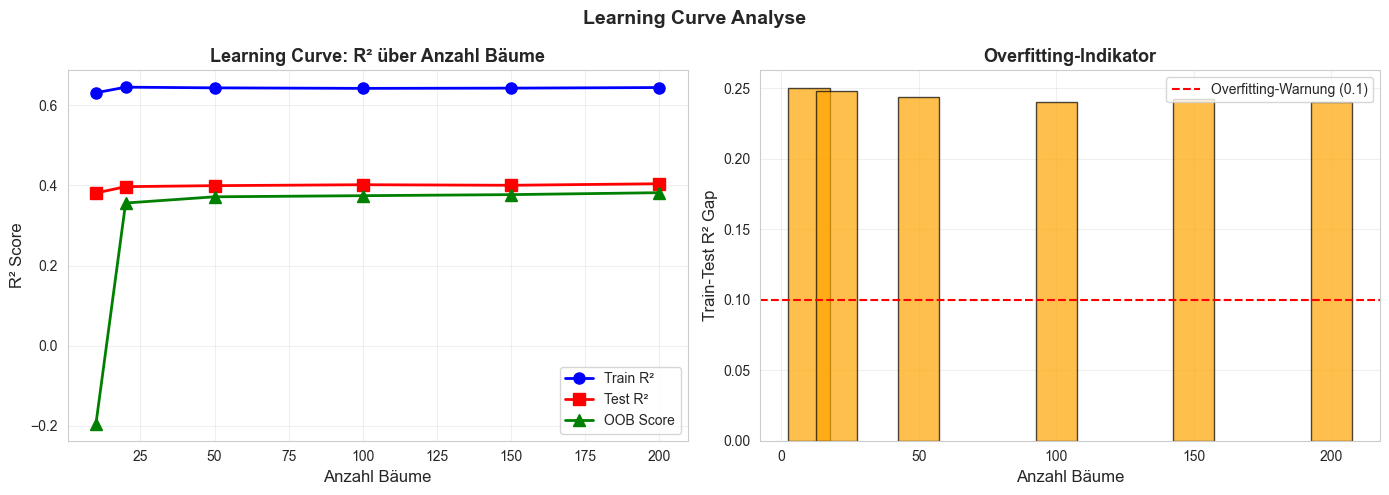

In [26]:
# ============================================================================
# LEARNING CURVE: Zeigt ab wann Overfitting beginnt
# ============================================================================
print("=" * 70)
print("LEARNING CURVE: R² über Anzahl Bäume")
print("=" * 70)
print("Berechne Learning Curve...")

n_trees_range = [10, 20, 50, 100, 150, 200]
train_r2_progress = []
test_r2_progress = []
oob_scores_progress = []

for n_trees in n_trees_range:
    print(f"  Training mit {n_trees} Bäumen...", end=" ")
    
    temp_rf = RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=rf_model.max_depth if hasattr(rf_model, 'max_depth') else MAX_DEPTH,
        min_samples_split=rf_model.min_samples_split if hasattr(rf_model, 'min_samples_split') else MIN_SAMPLES_SPLIT,
        min_samples_leaf=rf_model.min_samples_leaf if hasattr(rf_model, 'min_samples_leaf') else MIN_SAMPLES_LEAF,
        max_features=rf_model.max_features if hasattr(rf_model, 'max_features') else MAX_FEATURES,
        bootstrap=Bootstrap,
        oob_score=OOB_SCORE,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    temp_rf.fit(X_train, y_train)
    
    train_pred = temp_rf.predict(X_train)
    test_pred = temp_rf.predict(X_test)
    
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    train_r2_progress.append(train_r2)
    test_r2_progress.append(test_r2)
    oob_scores_progress.append(temp_rf.oob_score_ if OOB_SCORE else None)
    
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, OOB: {temp_rf.oob_score_:.4f}")

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(n_trees_range, train_r2_progress, 'b-o', label='Train R²', linewidth=2, markersize=8)
axes[0].plot(n_trees_range, test_r2_progress, 'r-s', label='Test R²', linewidth=2, markersize=8)
if oob_scores_progress[0] is not None:
    axes[0].plot(n_trees_range, oob_scores_progress, 'g-^', label='OOB Score', linewidth=2, markersize=8)
axes[0].set_xlabel('Anzahl Bäume', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Learning Curve: R² über Anzahl Bäume', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Train-Test Gap
gap = [train - test for train, test in zip(train_r2_progress, test_r2_progress)]
axes[1].bar(n_trees_range, gap, color='orange', alpha=0.7, edgecolor='black', width=15)
axes[1].axhline(y=0.1, color='r', linestyle='--', label='Overfitting-Warnung (0.1)')
axes[1].set_xlabel('Anzahl Bäume', fontsize=12)
axes[1].set_ylabel('Train-Test R² Gap', fontsize=12)
axes[1].set_title('Overfitting-Indikator', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Learning Curve Analyse', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)


## 3. Cross-Validation für robuste Evaluierung

Cross-Validation teilt die Trainingsdaten in mehrere Folds auf und testet das Modell auf jedem Fold.
Dies gibt eine robustere Schätzung der Modell-Performance als ein einfacher Train-Test Split.


10-FOLD CROSS-VALIDATION ERGEBNISSE

CV R² Scores pro Fold:
  Fold  1: 0.4237
  Fold  2: 0.3561
  Fold  3: 0.2542
  Fold  4: 0.4945
  Fold  5: 0.3520
  Fold  6: 0.4485
  Fold  7: 0.5200
  Fold  8: 0.3040
  Fold  9: 0.3166
  Fold 10: 0.3139

Statistik:
  Mean CV R²: 0.3783 (+/- 0.0840)
  Min CV R²:  0.2542
  Max CV R²:  0.5200
  OOB Score:  0.3821

Vergleich CV vs OOB:
  Differenz: 0.0037


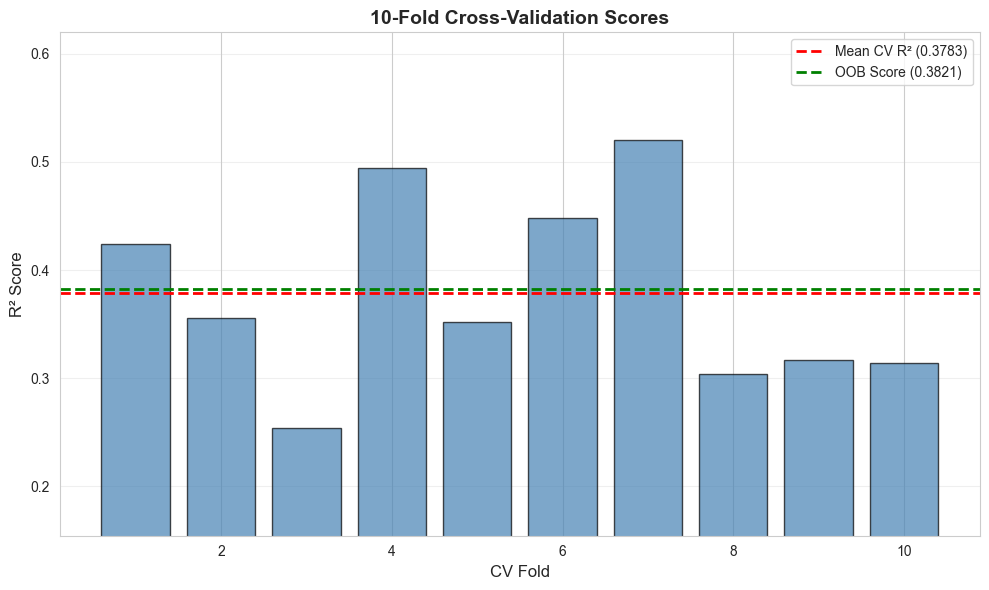

In [27]:
# ============================================================================
# CROSS-VALIDATION für robuste Evaluierung
# ============================================================================

cv_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=CV_FOLDS,
    scoring=SCORING,
    n_jobs=N_JOBS
)

print("=" * 70)
print(f"{CV_FOLDS}-FOLD CROSS-VALIDATION ERGEBNISSE")
print("=" * 70)
print(f"\nCV R² Scores pro Fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i:2d}: {score:.4f}")
print(f"\nStatistik:")
print(f"  Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"  Min CV R²:  {cv_scores.min():.4f}")
print(f"  Max CV R²:  {cv_scores.max():.4f}")
print(f"  OOB Score:  {rf_model.oob_score_:.4f}")
print(f"\nVergleich CV vs OOB:")
print(f"  Differenz: {abs(cv_scores.mean() - rf_model.oob_score_):.4f}")
print("=" * 70)

# Visualisierung der CV Scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, CV_FOLDS + 1), cv_scores, color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', linewidth=2, 
           label=f'Mean CV R² ({cv_scores.mean():.4f})')
plt.axhline(y=rf_model.oob_score_, color='g', linestyle='--', linewidth=2, 
           label=f'OOB Score ({rf_model.oob_score_:.4f})')
plt.xlabel('CV Fold', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title(f'{CV_FOLDS}-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim([max(0, cv_scores.min() - 0.1), min(1, cv_scores.max() + 0.1)])
plt.tight_layout()
plt.show()


## 4. Test-Set Evaluation


MODELL-EVALUIERUNG

Metrik                    Train        Test         Differenz   
------------------------------------------------------------
MSE                       0.2363       0.3929       0.1566      
RMSE                      0.4861       0.6269       0.1407      
MAE                       0.3799       0.4872       0.1074      
R² Score                  0.6444       0.4044       0.2400      

OOB Score: 0.3821
CV Mean R²: 0.3783


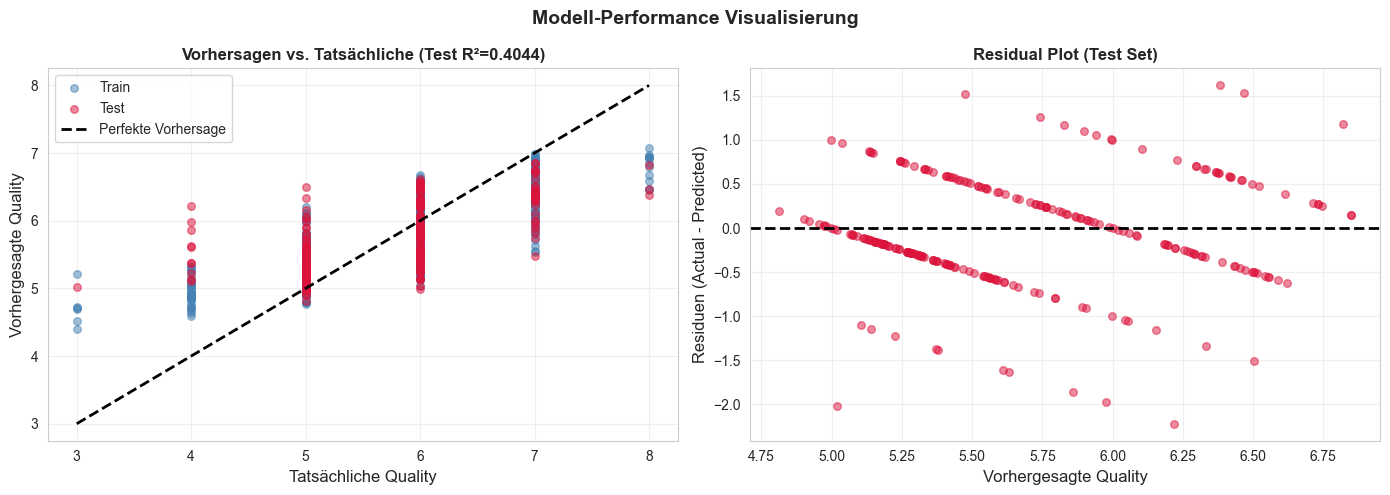

In [28]:
# ============================================================================
# VORHERSAGEN UND METRIKEN
# ============================================================================
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Metriken berechnen
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Residuen
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

print("=" * 70)
print("MODELL-EVALUIERUNG")
print("=" * 70)
print(f"\n{'Metrik':<25} {'Train':<12} {'Test':<12} {'Differenz':<12}")
print("-" * 60)
print(f"{'MSE':<25} {train_mse:<12.4f} {test_mse:<12.4f} {abs(train_mse - test_mse):<12.4f}")
print(f"{'RMSE':<25} {train_rmse:<12.4f} {test_rmse:<12.4f} {abs(train_rmse - test_rmse):<12.4f}")
print(f"{'MAE':<25} {train_mae:<12.4f} {test_mae:<12.4f} {abs(train_mae - test_mae):<12.4f}")
print(f"{'R² Score':<25} {train_r2:<12.4f} {test_r2:<12.4f} {abs(train_r2 - test_r2):<12.4f}")
print(f"\nOOB Score: {rf_model.oob_score_:.4f}")
print(f"CV Mean R²: {cv_scores.mean():.4f}")
print("=" * 70)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predictions vs Actual
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='steelblue', s=30, label='Train')
axes[0].scatter(y_test, y_test_pred, alpha=0.5, color='crimson', s=30, label='Test')
axes[0].plot([3, 8], [3, 8], 'k--', linewidth=2, label='Perfekte Vorhersage')
axes[0].set_xlabel('Tatsächliche Quality', fontsize=12)
axes[0].set_ylabel('Vorhergesagte Quality', fontsize=12)
axes[0].set_title(f'Vorhersagen vs. Tatsächliche (Test R²={test_r2:.4f})', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual Plot
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, color='crimson', s=30)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=2)
axes[1].set_xlabel('Vorhergesagte Quality', fontsize=12)
axes[1].set_ylabel('Residuen (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot (Test Set)', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.suptitle('Modell-Performance Visualisierung', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


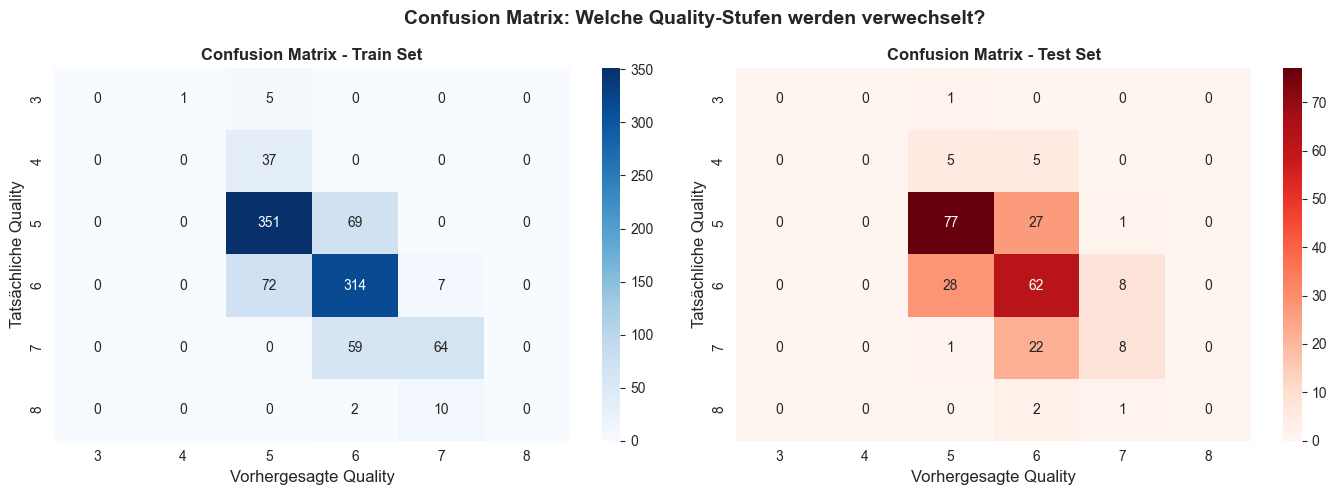


Accuracy (gerundete Vorhersagen):
  Train: 0.7356 (729/991 korrekt)
  Test:  0.5927 (147/248 korrekt)


In [29]:
# ============================================================================
# CONFUSION MATRIX: Vorhersagen auf ganze Zahlen runden
# ============================================================================

# Predictions runden und clippen
y_train_pred_rounded = np.clip(np.round(y_train_pred).astype(int), 3, 8)
y_test_pred_rounded = np.clip(np.round(y_test_pred).astype(int), 3, 8)

# Confusion Matrix berechnen
labels = sorted(y.unique())
cm_train = confusion_matrix(y_train, y_train_pred_rounded, labels=labels)
cm_test = confusion_matrix(y_test, y_test_pred_rounded, labels=labels)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Vorhergesagte Quality', fontsize=12)
axes[0].set_ylabel('Tatsächliche Quality', fontsize=12)
axes[0].set_title('Confusion Matrix - Train Set', fontweight='bold')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', 
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Vorhergesagte Quality', fontsize=12)
axes[1].set_ylabel('Tatsächliche Quality', fontsize=12)
axes[1].set_title('Confusion Matrix - Test Set', fontweight='bold')

plt.suptitle('Confusion Matrix: Welche Quality-Stufen werden verwechselt?', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Accuracy berechnen
train_accuracy = (y_train_pred_rounded == y_train).mean()
test_accuracy = (y_test_pred_rounded == y_test).mean()

print(f"\nAccuracy (gerundete Vorhersagen):")
print(f"  Train: {train_accuracy:.4f} ({int(train_accuracy * len(y_train))}/{len(y_train)} korrekt)")
print(f"  Test:  {test_accuracy:.4f} ({int(test_accuracy * len(y_test))}/{len(y_test)} korrekt)")


PER-QUALITY PERFORMANCE ANALYSE (Test Set)




,Quality,N_Samples,MAE,Accuracy,Mean_Pred,Bias
0,3,1,2.0192,0.0000,5.0192,2.0192
1,4,10,1.5513,0.0000,5.5513,1.5513
2,5,105,0.3725,0.7333,5.3631,0.3631
3,6,98,0.4005,0.6327,5.8280,-0.1720
4,7,31,0.6651,0.2581,6.3349,-0.6651
5,8,3,1.4427,0.0000,6.5573,-1.4427


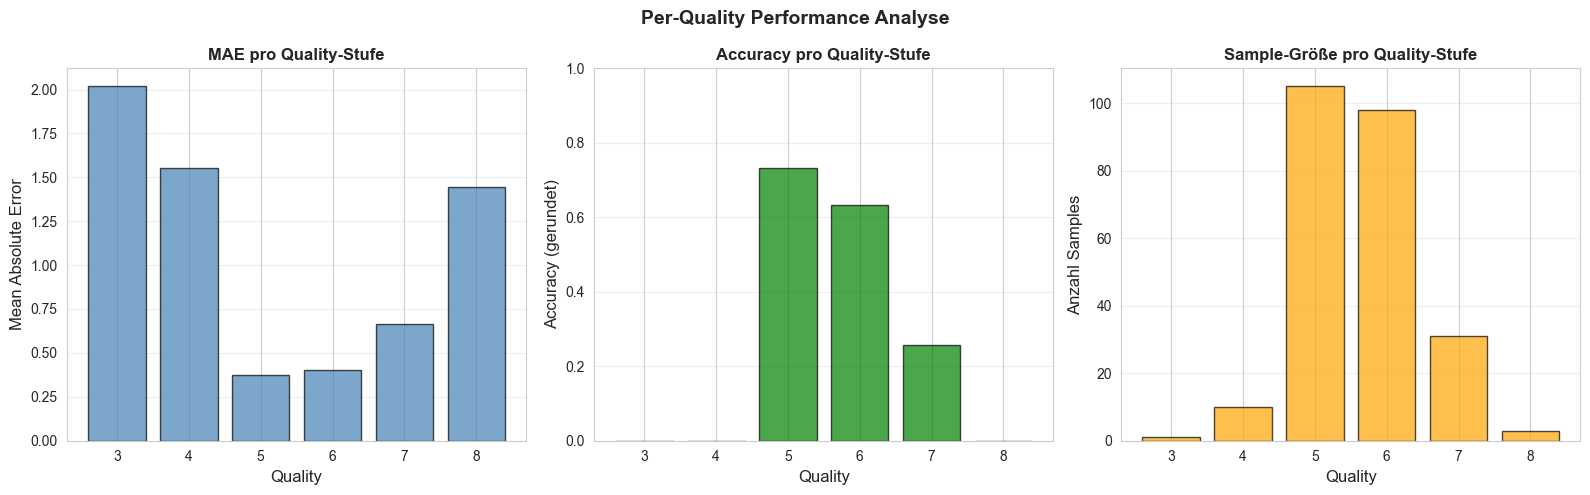


Interpretation:
- Quality 5 und 6 haben die meisten Samples und meist beste Accuracy
- Seltene Klassen (3, 4, 8) sind schwerer vorherzusagen
- Bias zeigt systematische Über-/Unterschätzung


In [30]:
# ============================================================================
# PER-QUALITY PERFORMANCE ANALYSE
# ============================================================================

print("=" * 80)
print("PER-QUALITY PERFORMANCE ANALYSE (Test Set)")
print("=" * 80)

quality_analysis = []
for q in sorted(y_test.unique()):
    mask = y_test == q
    n_samples = mask.sum()
    
    if n_samples > 0:
        q_actual = y_test[mask]
        q_pred = y_test_pred[mask]
        q_pred_rounded = y_test_pred_rounded[mask]
        
        mae = mean_absolute_error(q_actual, q_pred)
        accuracy = (q_pred_rounded == q_actual).mean()
        mean_pred = q_pred.mean()
        
        quality_analysis.append({
            'Quality': q,
            'N_Samples': n_samples,
            'MAE': mae,
            'Accuracy': accuracy,
            'Mean_Pred': mean_pred,
            'Bias': mean_pred - q
        })

quality_df = pd.DataFrame(quality_analysis)
print("\n")
display(quality_df.round(4))

# Visualisierung
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MAE pro Quality
axes[0].bar(quality_df['Quality'], quality_df['MAE'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error', fontsize=12)
axes[0].set_title('MAE pro Quality-Stufe', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Accuracy pro Quality
axes[1].bar(quality_df['Quality'], quality_df['Accuracy'], color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Accuracy (gerundet)', fontsize=12)
axes[1].set_title('Accuracy pro Quality-Stufe', fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

# Samples pro Quality
axes[2].bar(quality_df['Quality'], quality_df['N_Samples'], color='orange', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Quality', fontsize=12)
axes[2].set_ylabel('Anzahl Samples', fontsize=12)
axes[2].set_title('Sample-Größe pro Quality-Stufe', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Per-Quality Performance Analyse', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Quality 5 und 6 haben die meisten Samples und meist beste Accuracy")
print("- Seltene Klassen (3, 4, 8) sind schwerer vorherzusagen")
print("- Bias zeigt systematische Über-/Unterschätzung")


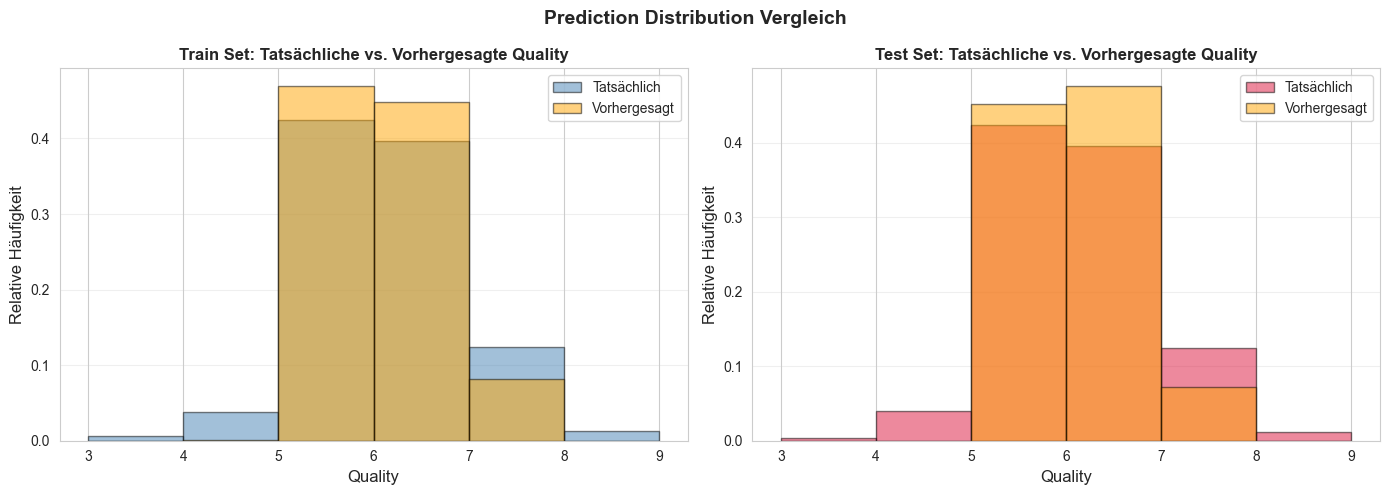


Verteilungsvergleich (Test Set):
Quality    Tatsächlich     Vorhergesagt    Differenz      
-------------------------------------------------------
3          1               0               -1             
4          10              0               -10            
5          105             112             7              
6          98              118             20             
7          31              18              -13            
8          3               0               -3             


In [31]:
# ============================================================================
# PREDICTION DISTRIBUTION VERGLEICH
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train Set
axes[0].hist(y_train, bins=range(3, 10), alpha=0.5, label='Tatsächlich', 
             color='steelblue', edgecolor='black', density=True)
axes[0].hist(y_train_pred_rounded, bins=range(3, 10), alpha=0.5, label='Vorhergesagt', 
             color='orange', edgecolor='black', density=True)
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Relative Häufigkeit', fontsize=12)
axes[0].set_title('Train Set: Tatsächliche vs. Vorhergesagte Quality', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Test Set
axes[1].hist(y_test, bins=range(3, 10), alpha=0.5, label='Tatsächlich', 
             color='crimson', edgecolor='black', density=True)
axes[1].hist(y_test_pred_rounded, bins=range(3, 10), alpha=0.5, label='Vorhergesagt', 
             color='orange', edgecolor='black', density=True)
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Relative Häufigkeit', fontsize=12)
axes[1].set_title('Test Set: Tatsächliche vs. Vorhergesagte Quality', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Prediction Distribution Vergleich', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Verteilungsstatistik
print("\nVerteilungsvergleich (Test Set):")
print(f"{'Quality':<10} {'Tatsächlich':<15} {'Vorhergesagt':<15} {'Differenz':<15}")
print("-" * 55)
for q in sorted(y_test.unique()):
    actual_count = (y_test == q).sum()
    pred_count = (y_test_pred_rounded == q).sum()
    print(f"{q:<10} {actual_count:<15} {pred_count:<15} {pred_count - actual_count:<15}")


## 5. Feature Importance Analyse


FEATURE IMPORTANCE

Top 10 Features:


,Feature,Importance
14,sulphate_alcohol_interaction,0.171660
13,alcohol_density_ratio,0.160769
10,alcohol,0.120111
9,sulphates,0.094852
12,acidity_ratio,0.072361
1,volatile acidity,0.067729
6,total sulfur dioxide,0.049254
15,free_sulfur_ratio,0.037894
2,citric acid,0.035917
7,density,0.033676


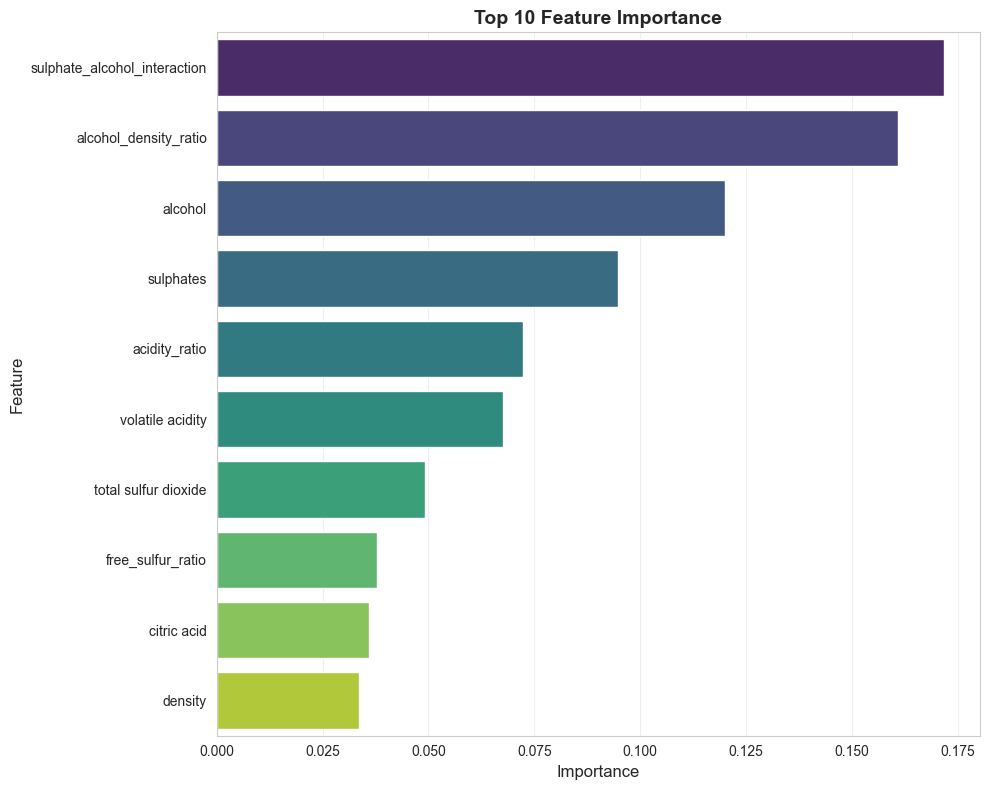

In [32]:
# Feature Importance extrahieren
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 70)
print("FEATURE IMPORTANCE")
print("=" * 70)
print("\nTop 10 Features:")
display(feature_importance.head(10))

# Visualisierung
plt.figure(figsize=(10, 8))
top_10_features = feature_importance.head(10)
sns.barplot(data=top_10_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importance', fontweight='bold', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Modell-Historie speichern


In [33]:
# ============================================================================
# MODELL-HISTORIE SPEICHERN
# ============================================================================

# Erstelle model_history Ordner falls nicht vorhanden
history_dir = 'model_history'
if not os.path.exists(history_dir):
    os.makedirs(history_dir)
    print(f"Ordner '{history_dir}' wurde erstellt.")

# Generiere Timestamp im Format HH-MM_DD-MM-YY
timestamp = datetime.now().strftime('%H-%M_%d-%m-%y')
filename = f"{timestamp}.csv"
filepath = os.path.join(history_dir, filename)

# Sammle alle wichtigen Metriken und Informationen
model_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'RandomForestRegressor',
    'dataset': DATA_PATH,
    'n_estimators': N_ESTIMATORS,
    # Verwendete feste Hyperparameter (aus GridSearch-Ergebnis 07.01.26)
    'max_depth': MAX_DEPTH,
    'min_samples_split': MIN_SAMPLES_SPLIT,
    'min_samples_leaf': MIN_SAMPLES_LEAF,
    'max_features': str(MAX_FEATURES),
    'max_samples': str(MAX_SAMPLES),
    'bootstrap': Bootstrap,
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE,
    'stratify': STRATIFY,
    'training_time_seconds': training_time,
    'training_time_minutes': training_time / 60,
    'n_train_samples': X_train.shape[0],
    'n_test_samples': X_test.shape[0],
    'n_features': X_train.shape[1],
    'train_mse': train_mse,
    'train_rmse': train_rmse,
    'train_mae': train_mae,
    'train_r2': train_r2,
    'test_mse': test_mse,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'train_test_rmse_diff': abs(train_rmse - test_rmse),
    'train_test_r2_diff': abs(train_r2 - test_r2),
    'gridsearch_used': False,
    'best_cv_score': REFERENCE_CV_R2,
    'cv_mean_score': cv_scores.mean(),
    'cv_std_score': cv_scores.std(),
    'oob_score': rf_model.oob_score_ if hasattr(rf_model, 'oob_score_') else None,
}

# Füge Top 5 Features hinzu
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    model_summary[f'top{i}_feature'] = row['Feature']
    model_summary[f'top{i}_importance'] = row['Importance']

# Füge Notes Spalte hinzu (leer für manuelle Eingaben)
model_summary['notes'] = ''

# Erstelle DataFrame und speichere als CSV
summary_df = pd.DataFrame([model_summary])
summary_df.to_csv(filepath, index=False)

print("=" * 80)
print(f"MODELL-ZUSAMMENFASSUNG GESPEICHERT")
print("=" * 80)
print(f"Datei: {filepath}")
print(f"Zeitstempel: {timestamp}")
print(f"\nKurzübersicht:")
print(f"  - Modell: Random Forest ({N_ESTIMATORS} Bäume)")
print(f"  - Train R²: {train_r2:.4f}")
print(f"  - Test R²: {test_r2:.4f}")
print(f"  - CV Mean R²: {cv_scores.mean():.4f}")
print(f"  - Train RMSE: {train_rmse:.4f}")
print(f"  - Test RMSE: {test_rmse:.4f}")
print(f"  - Training Zeit: {training_time:.2f}s")
print(f"  - Top Feature: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.4f})")
print("=" * 80)


MODELL-ZUSAMMENFASSUNG GESPEICHERT
Datei: model_history\13-43_07-01-26.csv
Zeitstempel: 13-43_07-01-26

Kurzübersicht:
  - Modell: Random Forest (200 Bäume)
  - Train R²: 0.6444
  - Test R²: 0.4044
  - CV Mean R²: 0.3783
  - Train RMSE: 0.4861
  - Test RMSE: 0.6269
  - Training Zeit: 75.20s
  - Top Feature: sulphate_alcohol_interaction (0.1717)
